In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import re
import string
import urllib
import gzip
import gensim
import time
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from collections import Counter

from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, Flatten, MaxPool1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data collection

Getting real about fake news - A Kaggle Dataset :

FAKE NEWS Dataset - [link](https://https://www.kaggle.com/mrisdal/fake-news)

REAL NEWS Dataset - [link](https://www.kaggle.com/anthonyc1/gathering-real-news-for-oct-dec-2016/notebook)

In [3]:
fake_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Getting Real about Fake News_Kaggle/fake.csv")
real_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Getting Real about Fake News_Kaggle/real.csv")

#size of the datasets
nRow, nCol = fake_news.shape
print(f'There are {nRow} rows and {nCol} columns in the Fake News Dataset')

nRow1, nCol1 = real_news.shape
print(f'There are {nRow1} rows and {nCol1} columns in the Real News Dataset')

There are 12999 rows and 20 columns in the Fake News Dataset
There are 15712 rows and 11 columns in the Real News Dataset


In [4]:
# essential columns
fake_news1 = fake_news[['title', 'text','language','site_url']]
fake_news1 = fake_news1[fake_news1.language == 'english']
fake_news1['title'].fillna(value="", inplace=True)

# drop null 'text' rows as there is no context of the article
fake_news1.dropna(axis=0, inplace=True, subset=['text'])

# data shuffling and resetting index to avoid bias
fake_news1 = fake_news1.sample(frac=1.0) 
fake_news1.reset_index(drop=True,inplace=True)
fake_news1.head()

,title,text,language,site_url
0,Americans Need to Exercise Their Freedoms and ...,"November 8, 2016, is election day. On Tuesday,...",english,guardianlv.com
1,A Bonus Insult to Veterans,‹ › Arnaldo Rodgers is a trained and educated ...,english,veteransnewsnow.com
2,Quit Smoking! Smoking Cigarettes Causes 150 Ge...,You Are Here: Home » Health News » Quit Smokin...,english,undergroundhealth.com
3,And You Thought the Silver Market was Rigged!,And You Thought the Silver Market was Rigged! ...,english,silverdoctors.com
4,Rule or Ruin,Here's something interesting from The Unz Revi...,english,unz.com


In [5]:
print(fake_news1.shape)

(12357, 4)


* Now, the no. of columns reduce from 12999 to 12357 rows and from 20 to 4 columns.

In [6]:
#feature extraction
fake_news2 = fake_news1[['title', 'text','site_url']]

#data labelling
fake_news2['label'] = 'fake'
fake_news2.head()

,title,text,site_url,label
0,Americans Need to Exercise Their Freedoms and ...,"November 8, 2016, is election day. On Tuesday,...",guardianlv.com,fake
1,A Bonus Insult to Veterans,‹ › Arnaldo Rodgers is a trained and educated ...,veteransnewsnow.com,fake
2,Quit Smoking! Smoking Cigarettes Causes 150 Ge...,You Are Here: Home » Health News » Quit Smokin...,undergroundhealth.com,fake
3,And You Thought the Silver Market was Rigged!,And You Thought the Silver Market was Rigged! ...,silverdoctors.com,fake
4,Rule or Ruin,Here's something interesting from The Unz Revi...,unz.com,fake


In [7]:
#all site_urls
site_urls = fake_news2['site_url']

#removing domain extensions
site_urls2 = [x.split('.',1)[0] for x in site_urls]

#replacing the old site_url column with these values
fake_news2['site_url'] = site_urls2
fake_news2.head()

,title,text,site_url,label
0,Americans Need to Exercise Their Freedoms and ...,"November 8, 2016, is election day. On Tuesday,...",guardianlv,fake
1,A Bonus Insult to Veterans,‹ › Arnaldo Rodgers is a trained and educated ...,veteransnewsnow,fake
2,Quit Smoking! Smoking Cigarettes Causes 150 Ge...,You Are Here: Home » Health News » Quit Smokin...,undergroundhealth,fake
3,And You Thought the Silver Market was Rigged!,And You Thought the Silver Market was Rigged! ...,silverdoctors,fake
4,Rule or Ruin,Here's something interesting from The Unz Revi...,unz,fake


In [8]:
#feature extraction
real_news2 = real_news[['title', 'content', 'publication']]

#data labelling
real_news2['label'] = 'real'
real_news2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,title,content,publication,label
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,real
1,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",New York Times,real
2,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,New York Times,real
3,U.S. Plans to Step Up Military Campaign Agains...,"ABU DHABI, United Arab Emirates — The Obama...",New York Times,real
4,272 Slaves Were Sold to Save Georgetown. What ...,WASHINGTON — The human cargo was loaded on ...,New York Times,real


**Data Concatenation**

In [9]:
#rename features in our final datasets
newlabels = ['title', 'content', 'publication', 'label']
real_news2.columns = newlabels
fake_news2.columns = newlabels

#dataframe combined to form a new final Fake News Detection dataset
dataframes = [fake_news2, real_news2]
final_dataset = pd.concat(dataframes)
final_dataset

,title,content,publication,label
0,Americans Need to Exercise Their Freedoms and ...,"November 8, 2016, is election day. On Tuesday,...",guardianlv,fake
1,A Bonus Insult to Veterans,‹ › Arnaldo Rodgers is a trained and educated ...,veteransnewsnow,fake
2,Quit Smoking! Smoking Cigarettes Causes 150 Ge...,You Are Here: Home » Health News » Quit Smokin...,undergroundhealth,fake
3,And You Thought the Silver Market was Rigged!,And You Thought the Silver Market was Rigged! ...,silverdoctors,fake
4,Rule or Ruin,Here's something interesting from The Unz Revi...,unz,fake
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,real
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,real
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,real
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,real


In [10]:
# Fill any null fields
final_dataset.title.fillna("", inplace=True)
final_dataset.content.fillna("", inplace=True)

In [11]:
final_dataset

,title,content,publication,label
0,Americans Need to Exercise Their Freedoms and ...,"November 8, 2016, is election day. On Tuesday,...",guardianlv,fake
1,A Bonus Insult to Veterans,‹ › Arnaldo Rodgers is a trained and educated ...,veteransnewsnow,fake
2,Quit Smoking! Smoking Cigarettes Causes 150 Ge...,You Are Here: Home » Health News » Quit Smokin...,undergroundhealth,fake
3,And You Thought the Silver Market was Rigged!,And You Thought the Silver Market was Rigged! ...,silverdoctors,fake
4,Rule or Ruin,Here's something interesting from The Unz Revi...,unz,fake
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,real
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,real
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,real
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,real


In [12]:
final_dataset['label'] = final_dataset['label'].map({'real': 1, 'fake': 0})
final_dataset

,title,content,publication,label
0,Americans Need to Exercise Their Freedoms and ...,"November 8, 2016, is election day. On Tuesday,...",guardianlv,0
1,A Bonus Insult to Veterans,‹ › Arnaldo Rodgers is a trained and educated ...,veteransnewsnow,0
2,Quit Smoking! Smoking Cigarettes Causes 150 Ge...,You Are Here: Home » Health News » Quit Smokin...,undergroundhealth,0
3,And You Thought the Silver Market was Rigged!,And You Thought the Silver Market was Rigged! ...,silverdoctors,0
4,Rule or Ruin,Here's something interesting from The Unz Revi...,unz,0
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,1
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,1
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,1
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,1


In [13]:
final_dataset['content'] = final_dataset['title'] + " " + final_dataset['content']
final_dataset

,title,content,publication,label
0,Americans Need to Exercise Their Freedoms and ...,Americans Need to Exercise Their Freedoms and ...,guardianlv,0
1,A Bonus Insult to Veterans,A Bonus Insult to Veterans ‹ › Arnaldo Rodgers...,veteransnewsnow,0
2,Quit Smoking! Smoking Cigarettes Causes 150 Ge...,Quit Smoking! Smoking Cigarettes Causes 150 Ge...,undergroundhealth,0
3,And You Thought the Silver Market was Rigged!,And You Thought the Silver Market was Rigged! ...,silverdoctors,0
4,Rule or Ruin,Rule or Ruin Here's something interesting from...,unz,0
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,An eavesdropping Uber driver saved his 16-year...,Washington Post,1
15708,Plane carrying six people returning from a Cav...,Plane carrying six people returning from a Cav...,Washington Post,1
15709,After helping a fraction of homeowners expecte...,After helping a fraction of homeowners expecte...,Washington Post,1
15710,"Yes, this is real: Michigan just banned bannin...","Yes, this is real: Michigan just banned bannin...",Washington Post,1


#Data Preprocessing

In [14]:
final_dataset = final_dataset[['content','label']]
final_dataset

,content,label
0,Americans Need to Exercise Their Freedoms and ...,0
1,A Bonus Insult to Veterans ‹ › Arnaldo Rodgers...,0
2,Quit Smoking! Smoking Cigarettes Causes 150 Ge...,0
3,And You Thought the Silver Market was Rigged! ...,0
4,Rule or Ruin Here's something interesting from...,0
...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,1
15708,Plane carrying six people returning from a Cav...,1
15709,After helping a fraction of homeowners expecte...,1
15710,"Yes, this is real: Michigan just banned bannin...",1


In [15]:
def preprocess_text(df, remove_special=True):
    texts = df['content'].copy()
    labels = df['label'].copy()

    #Remove links 
    df["content"] = df["content"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["content"] = df["content"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["content"] = df["content"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["content"] = df["content"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
        
    #Strip Punctation
    df["content"] = df["content"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["content"] = df["content"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["content"] = df["content"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert content to lowercase
    df["content"] = df["content"].apply(lambda x: x.lower())
        
    #Remove multiple letter repeating words
    df["content"] = df["content"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["content"] = df["content"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["content"] = df["content"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))
    
    return df

#Preprocessing of entered Text
new_df = preprocess_text(final_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [16]:
#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(new_df)) 
new_df["no. of. words"] = new_df["content"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 28069
After : Number of posts 27472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#Feature Engineering

##80-20 Split

In [99]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_df['content'], new_df.label, test_size=0.2)

# determining the shapes of training and testing sets
print("Shape of Independent training variable, x :",X_train1.shape)
print("Shape of Dependent training variable, y :",y_train1.shape)

print("Shape of Independent test variable, x :",X_test1.shape)
print("Shape of Dependent test variable, y :",y_test1.shape)

Shape of Independent training variable, x : (21977,)
Shape of Dependent training variable, y : (21977,)
Shape of Independent test variable, x : (5495,)
Shape of Dependent test variable, y : (5495,)


In [100]:
X_train1[0]

0    house republicans fret about winning their hea...
0    americans need  exercise their freedoms  vote ...
Name: content, dtype: object

Construct models with TF-IDF Vectorizer for better accuracy.

TFIDF or term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.


In [101]:
X_train1

8728      better titles   afflecks solo batman film tha...
9913     kale  about  have  identity crisis kale  getti...
1506      about time maryland school official declares ...
7337     comment   reiki actually works  science part  ...
125      investing   emotional trust fund  your childre...
                               ...                        
4788     podesta takes swipe  assange   wikileaks conti...
1196     former drug industry executives charged  kickb...
3908     undercover video exposes obamas plan  make ame...
5559       stop  craziness  christmas from outshining  ...
11838    china pledges further opening  leaders scrambl...
Name: content, Length: 21977, dtype: object

In [102]:
tfidf_vectorizer1 = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train1 = tfidf_vectorizer1.fit_transform(X_train1)
tfidf_test1 = tfidf_vectorizer1.transform(X_test1)
tfidf_features1 = tfidf_vectorizer1.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#DNN MODEL



In [103]:
tfidf_train1 = tfidf_train1.todense()
tfidf_test1 = tfidf_test1.todense()

# Creating model
neural_network1 = Sequential()
neural_network1.add(Dense(64, input_dim=len(tfidf_features1), activation='relu'))
neural_network1.add(Dropout(0.1))
neural_network1.add(Dense(64, activation='relu'))
neural_network1.add(Dropout(0.1))
neural_network1.add(Dense(1, activation='sigmoid'))
neural_network1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(neural_network1.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                19264     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 23,489
Trainable params: 23,489
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
history1 = neural_network1.fit(tfidf_train1, y_train1, epochs=10, batch_size=512, verbose=0)

_,test_acc1 = neural_network1.evaluate(tfidf_test1, y_test1, verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc1 * 100, 2)))

Testing Acc. of DNN: 85.57 %


In [105]:
y_pred1 = (neural_network1.predict(tfidf_test1) >= 0.5).astype("int32")

In [106]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test1,y_pred1),2))

The Accuracy Score Is :  0.86


In [107]:
print(confusion_matrix(y_test1,y_pred1))
print(print(classification_report(y_test1,y_pred1)))

[[1889  484]
 [ 309 2813]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      2373
           1       0.85      0.90      0.88      3122

    accuracy                           0.86      5495
   macro avg       0.86      0.85      0.85      5495
weighted avg       0.86      0.86      0.85      5495

None


In [108]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

## 70-30 Split

In [110]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_df['content'], new_df.label, test_size=0.3)

# determining the shapes of training and testing sets
print("Shape of Independent training variable, x :",X_train2.shape)
print("Shape of Dependent training variable, y :",y_train2.shape)

print("Shape of Independent test variable, x :",X_test2.shape)
print("Shape of Dependent test variable, y :",y_test2.shape)

Shape of Independent training variable, x : (19230,)
Shape of Dependent training variable, y : (19230,)
Shape of Independent test variable, x : (8242,)
Shape of Dependent test variable, y : (8242,)


In [111]:
tfidf_vectorizer2 = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train2 = tfidf_vectorizer2.fit_transform(X_train2)
tfidf_test2 = tfidf_vectorizer2.transform(X_test2)
tfidf_features2 = tfidf_vectorizer2.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [112]:
tfidf_train2 = tfidf_train2.todense()
tfidf_test2 = tfidf_test2.todense()

neural_network2 = Sequential()

neural_network2.add(Dense(64, input_dim=len(tfidf_features2), activation='relu'))
neural_network2.add(Dropout(0.1))
neural_network2.add(Dense(64, activation='relu'))
neural_network2.add(Dropout(0.1))
neural_network2.add(Dense(1, activation='sigmoid'))
neural_network2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = neural_network2.fit(tfidf_train2, y_train2, epochs=50, batch_size=512, verbose=0)

_,test_acc2 = neural_network2.evaluate(tfidf_test2,y_test2,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc2 * 100, 2)))

Testing Acc. of DNN: 86.5 %


In [113]:
y_pred2 = (neural_network2.predict(tfidf_test2) >= 0.5).astype("int32")

In [114]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test2,y_pred2),2))

The Accuracy Score Is :  0.86


In [115]:
print(confusion_matrix(y_test2,y_pred2))
print(print(classification_report(y_test2,y_pred2)))

[[3059  516]
 [ 597 4070]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3575
           1       0.89      0.87      0.88      4667

    accuracy                           0.86      8242
   macro avg       0.86      0.86      0.86      8242
weighted avg       0.87      0.86      0.87      8242

None


##64-33 Split

In [116]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(new_df['content'], new_df.label, test_size=0.33)

# determining the shapes of training and testing sets
print("Shape of Independent training variable, x :",X_train3.shape)
print("Shape of Dependent training variable, y :",y_train3.shape)

print("Shape of Independent test variable, x :",X_test3.shape)
print("Shape of Dependent test variable, y :",y_test3.shape)

Shape of Independent training variable, x : (18406,)
Shape of Dependent training variable, y : (18406,)
Shape of Independent test variable, x : (9066,)
Shape of Dependent test variable, y : (9066,)


In [117]:
tfidf_vectorizer3 = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train3 = tfidf_vectorizer3.fit_transform(X_train3)
tfidf_test3 = tfidf_vectorizer3.transform(X_test3)
tfidf_features3 = tfidf_vectorizer3.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [118]:
tfidf_train3 = tfidf_train3.todense()
tfidf_test3 = tfidf_test3.todense()

neural_network3 = Sequential()

neural_network3.add(Dense(64, input_dim=len(tfidf_features3), activation='relu'))
neural_network3.add(Dropout(0.1))
neural_network3.add(Dense(64, activation='relu'))
neural_network3.add(Dropout(0.1))
neural_network3.add(Dense(1, activation='sigmoid'))
neural_network3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history3 = neural_network3.fit(tfidf_train3, y_train3, epochs=50, batch_size=512, verbose=0)

_,test_acc3 = neural_network3.evaluate(tfidf_test3,y_test3,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc3 * 100, 2)))

Testing Acc. of DNN: 86.58 %


In [119]:
y_pred3 = (neural_network3.predict(tfidf_test3) >= 0.5).astype("int32")

In [120]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test3,y_pred3),2))

The Accuracy Score Is :  0.87


In [121]:
print(confusion_matrix(y_test3,y_pred3))
print(print(classification_report(y_test3,y_pred3)))

[[3243  620]
 [ 597 4606]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3863
           1       0.88      0.89      0.88      5203

    accuracy                           0.87      9066
   macro avg       0.86      0.86      0.86      9066
weighted avg       0.87      0.87      0.87      9066

None


##50-50 Split

In [122]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(new_df['content'], new_df.label, test_size=0.5)

# determining the shapes of training and testing sets
print("Shape of Independent training variable, x :",X_train4.shape)
print("Shape of Dependent training variable, y :",y_train4.shape)

print("Shape of Independent test variable, x :",X_test4.shape)
print("Shape of Dependent test variable, y :",y_test4.shape)

Shape of Independent training variable, x : (13736,)
Shape of Dependent training variable, y : (13736,)
Shape of Independent test variable, x : (13736,)
Shape of Dependent test variable, y : (13736,)


In [123]:
tfidf_vectorizer4 = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train4 = tfidf_vectorizer4.fit_transform(X_train4)
tfidf_test4 = tfidf_vectorizer4.transform(X_test4)
tfidf_features4 = tfidf_vectorizer4.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [124]:
tfidf_train4 = tfidf_train4.todense()
tfidf_test4 = tfidf_test4.todense()

neural_network4 = Sequential()

neural_network4.add(Dense(64, input_dim=len(tfidf_features4), activation='relu'))
neural_network4.add(Dropout(0.1))
neural_network4.add(Dense(64, activation='relu'))
neural_network4.add(Dropout(0.1))
neural_network4.add(Dense(1, activation='sigmoid'))
neural_network4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history4 = neural_network4.fit(tfidf_train4, y_train4, epochs=50, batch_size=512, verbose=0)

_,test_acc4 = neural_network4.evaluate(tfidf_test4,y_test4,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc4 * 100, 2)))

Testing Acc. of DNN: 86.29 %


In [125]:
y_pred4 = (neural_network4.predict(tfidf_test4) >= 0.5).astype("int32")

In [126]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test4,y_pred4),2))

The Accuracy Score Is :  0.86


In [127]:
print(confusion_matrix(y_test4,y_pred4))
print(print(classification_report(y_test4,y_pred4)))

[[4900 1052]
 [ 831 6953]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      5952
           1       0.87      0.89      0.88      7784

    accuracy                           0.86     13736
   macro avg       0.86      0.86      0.86     13736
weighted avg       0.86      0.86      0.86     13736

None


##30-70 Split

In [128]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(new_df['content'], new_df.label, test_size=0.7)

# determining the shapes of training and testing sets
print("Shape of Independent training variable, x :",X_train5.shape)
print("Shape of Dependent training variable, y :",y_train5.shape)

print("Shape of Independent test variable, x :",X_test5.shape)
print("Shape of Dependent test variable, y :",y_test5.shape)

Shape of Independent training variable, x : (8241,)
Shape of Dependent training variable, y : (8241,)
Shape of Independent test variable, x : (19231,)
Shape of Dependent test variable, y : (19231,)


In [129]:
tfidf_vectorizer5 = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train5 = tfidf_vectorizer5.fit_transform(X_train5)
tfidf_test5 = tfidf_vectorizer5.transform(X_test5)
tfidf_features5 = tfidf_vectorizer5.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [130]:
tfidf_train5 = tfidf_train5.todense()
tfidf_test5 = tfidf_test5.todense()

neural_network5 = Sequential()

neural_network5.add(Dense(64, input_dim=len(tfidf_features5), activation='relu'))
neural_network5.add(Dropout(0.1))
neural_network5.add(Dense(64, activation='relu'))
neural_network5.add(Dropout(0.1))
neural_network5.add(Dense(1, activation='sigmoid'))
neural_network5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history5 = neural_network5.fit(tfidf_train5, y_train5, epochs=50, batch_size=512, verbose=0)

_,test_acc5 = neural_network5.evaluate(tfidf_test5,y_test5,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc5 * 100, 2)))

Testing Acc. of DNN: 85.33 %


In [131]:
y_pred5 = (neural_network5.predict(tfidf_test5) >= 0.5).astype("int32")

In [132]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test5,y_pred5),2))

The Accuracy Score Is :  0.85


In [133]:
print(confusion_matrix(y_test5,y_pred5))
print(print(classification_report(y_test5,y_pred5)))

[[6946 1326]
 [1496 9463]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      8272
           1       0.88      0.86      0.87     10959

    accuracy                           0.85     19231
   macro avg       0.85      0.85      0.85     19231
weighted avg       0.85      0.85      0.85     19231

None


We use word embeddings, which converts text data, i.e., words into vectors. It represents every word in an n-dimensional dense vector where similar words will have a similar vector. The more efficient word embeddings techniques which have proven there capability to convert words into vectors are GloVe and Word2Vec.


DNN : GloVe word embedding technique has been used to calculate word embeddings using a co-occurrence matrix in between words within fake news tweets, which is called the embedding matrix. The embedding matrix is used to represent the tweets into dense vectors.

RNN: A recurrent neural network is useful
because it allows for the intermediate values (states) to
store information about past inputs for a time that is
not set a priori. The RNN uses
the secret state to store the state of each moment, and
the state depends on the previous moment and current
input. The new secret state effectively capitalizes on
the past knowledge. the gradient descent method is difficult to implement because of the well-known gradient
vanishing/explosion problem [67]. To solve these
two separate issues, research is being performed on
Long Short-Term Memory (LSTM), GRU, etc.

LSTM: It is a deep RNN which is more reliable than the traditional RNN when
used in tasks with long time lags. The main difference
between an RNN and an LSTM is that an RNN has a
single tanh layer, while an LSTM has four interactive
LSTM layers


Though LSTM uses a certain kind of RNN. LSTM
learning techniques are able to learn long term
dependencies. Although LSTM cannot learn to fill
a wide gap in knowledge, RNNs do not have a gap
problem. LSTM minimizes the number of losses.
LSTM embraces character sequences of varying
lengths, such so that no linguistic features are 
needed to be extracted.


GRU: The GRU has the same structure as either a basic
RNN or STM, except the GRU updates the hidden state [71], [72].. The key difference between
LSTM and GRU is that LSTM combines forget and
input layers into a single ‘‘update gate’’, combines
cell state and hidden state, and is more convenient and commo

# Comparision

In [134]:
score_1 = accuracy_score(y_test1,y_pred1)
score_2 = accuracy_score(y_test2,y_pred2)
score_3 = accuracy_score(y_test3,y_pred3)
score_4 = accuracy_score(y_test4,y_pred4)
score_5 = accuracy_score(y_test5,y_pred5)
results = pd.DataFrame([["80:20 split",format(score_3*100,".2f")],["70:30 split",format(score_2*100,".2f")], ["67:33 split",format(score_1*100,".2f")],
                       ["50:50 split",format(score_4*100,".2f")],["30:70 split",format(score_5*100,".2f")]], columns=["Train:Test Split","Accuracy (%)"])
results

,Train:Test Split,Accuracy (%)
0,80:20 split,86.58
1,70:30 split,86.50
2,67:33 split,85.57
3,50:50 split,86.29
4,30:70 split,85.33


KeyError: ignored

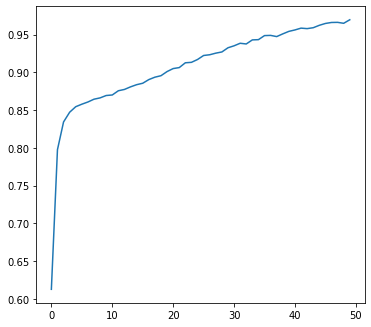

In [135]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('DNN model 63:33 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('DNN model 70:30 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 3)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('DNN model 80:20 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 4)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('DNN model 50:50 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 5)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('DNN model 30:70 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('DNN model 63:33 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('DNN model 70:30 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 3)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('DNN model 80:20 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 4)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('DNN model 50:50 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 5)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('DNN model 30:70 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.show()